# Analyzing Call Targets

## Setup

In [1]:
# load libraries

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import os
from typing import *

# with this amount of data, some figures would turn out very complex as svg
%config InlineBackend.figure_format='png'

plt.rcdefaults()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

# monospace font
monospace = fm.FontProperties(family='monospace')

In [2]:
# figure export helpers

os.makedirs("graphs", exist_ok=True)

# setting width & height explicitly allows us to reliably center pie charts rather than having matplotlib automatically crop to fit all labels and such
# honestly even this isn't perfect. it's somehow impossible to find good info on this online and this is as close as i could get, but it's horrible
def save_and_resize_fig(name, width, height):
	fig = plt.gcf()
	assert len(fig.axes) == 1
	fig.set_size_inches(width, height)
	fig.axes[0].set_xlim(-width/2, width/2)
	fig.axes[0].set_ylim(-height/2, height/2)
	# no padding so it's obvious when the image was expanded to fit extra stuff
	save_fig(name, bbox_inches=0, pad_inches=0)

def save_fig(name, **kwargs):
	plt.savefig(os.path.join("graphs", name), dpi=300, **kwargs)

In [3]:
def percentage_desc(k, n):
	return f"{k} / {n} = {100 * k / n:.4f}%"

In [4]:
all_calls = pd.read_csv(
    "resolved-calls/cross_crate_calls.csv",
    names=[
        "receiver",
        "receiver_generics",
        "target",
        "target_type_generics",
        "target_function_generics",
        "caller_crate",
        "target_crate",
        "macro",
        "count",
    ],
    sep=",",
    keep_default_na=False,
    dtype=str,
)
all_calls["count"] = all_calls["count"].astype(int)
total = all_calls["count"].sum()
print(f"Loaded {total} calls")


Loaded 87060395 calls


In [5]:
all_calls.sort_values(by="count", ascending=False, inplace=True)
all_calls

,receiver,receiver_generics,target,target_type_generics,target_function_generics,caller_crate,target_crate,macro,count
224858,,,quote::__private::push_ident,,,serde_derive,quote,quote::quote,63393
14881389,F,,core::ops::function::FnMut::call_mut,(&T),,partition_point_veb_layout,core,,48510
68345,T,,core::default::Default::default,,,tinyvec,core,,43450
214020,,,libsecp256k1_core::field::FieldStorage::new,,,libsecp256k1,libsecp256k1_core,,34816
13330649,F,,core::ops::function::FnMut::call_mut,(usize),,unroll_fn,core,,32896
3734646,,,core::fmt::Formatter::write_str,,,unicode_types,core,core::fmt::macros::Debug,32705
8612716,usize,,core::clone::Clone::clone,,,pseudotex,core,,31560
224251,,,quote::__private::push_colon2,,,serde_derive,quote,quote::quote,28197
2653753,,,core::fmt::Formatter::write_str,,,opcua_types,core,core::fmt::macros::Debug,27944
1440175,,,sp_weights::weight_v2::Weight::saturating_add,,,frame_support,sp_weights,,25228


In [6]:
# combine entries past a certain rank into "x others", expecting them to be sorted
def cut_off_after_top(count: int, counts: pd.DataFrame) -> pd.DataFrame:
	trimmed = counts[:count].copy()
	dropped_count = len(counts) - count
	total = counts['count'].sum()
	trimmed.loc[f"{dropped_count} others"] = total - trimmed['count'].sum()
	return trimmed

In [7]:
# group by the given columns, summing the counts for any combined entries
def sum_counts(frame, columns: List[str]) -> pd.DataFrame:
	frame = frame.groupby(columns)['count'].sum().sort_values(ascending=False).to_frame()
	frame.reset_index(inplace=True)
	return frame

In [8]:
# number of calls by crate they originate from
sum_counts(all_calls, ["caller_crate"])

,caller_crate,count
0,syn,596378
1,fhir,318963
2,serde_derive,223777
3,gcp_client,194165
4,aws_sdk_ec2,182631
5,steam_vent_proto,179026
6,tikv_client_proto,169366
7,tokio,164675
8,df_ls_structure,158412
9,cfn,156433


---

# Overall Insights

Note: "Targets" refer to trait functions as one object. "Calls" incorporate the receiver type as well, equating to a specific concrete function call most of the time. (Trait generics and blanket impls are mechanisms making this metric under- and over-approximate, respectively, the actual concrete code paths.)

## Call Frequency Distribution

In [9]:
def compute_totals(cumulative: pd.DataFrame):
	sums = cumulative['count'].cumsum()
	total = sums.iloc[-1]
	cumulative['total'] = sums / total

cumulative_counts = sum_counts(all_calls, ['target', 'receiver'])
compute_totals(cumulative_counts)

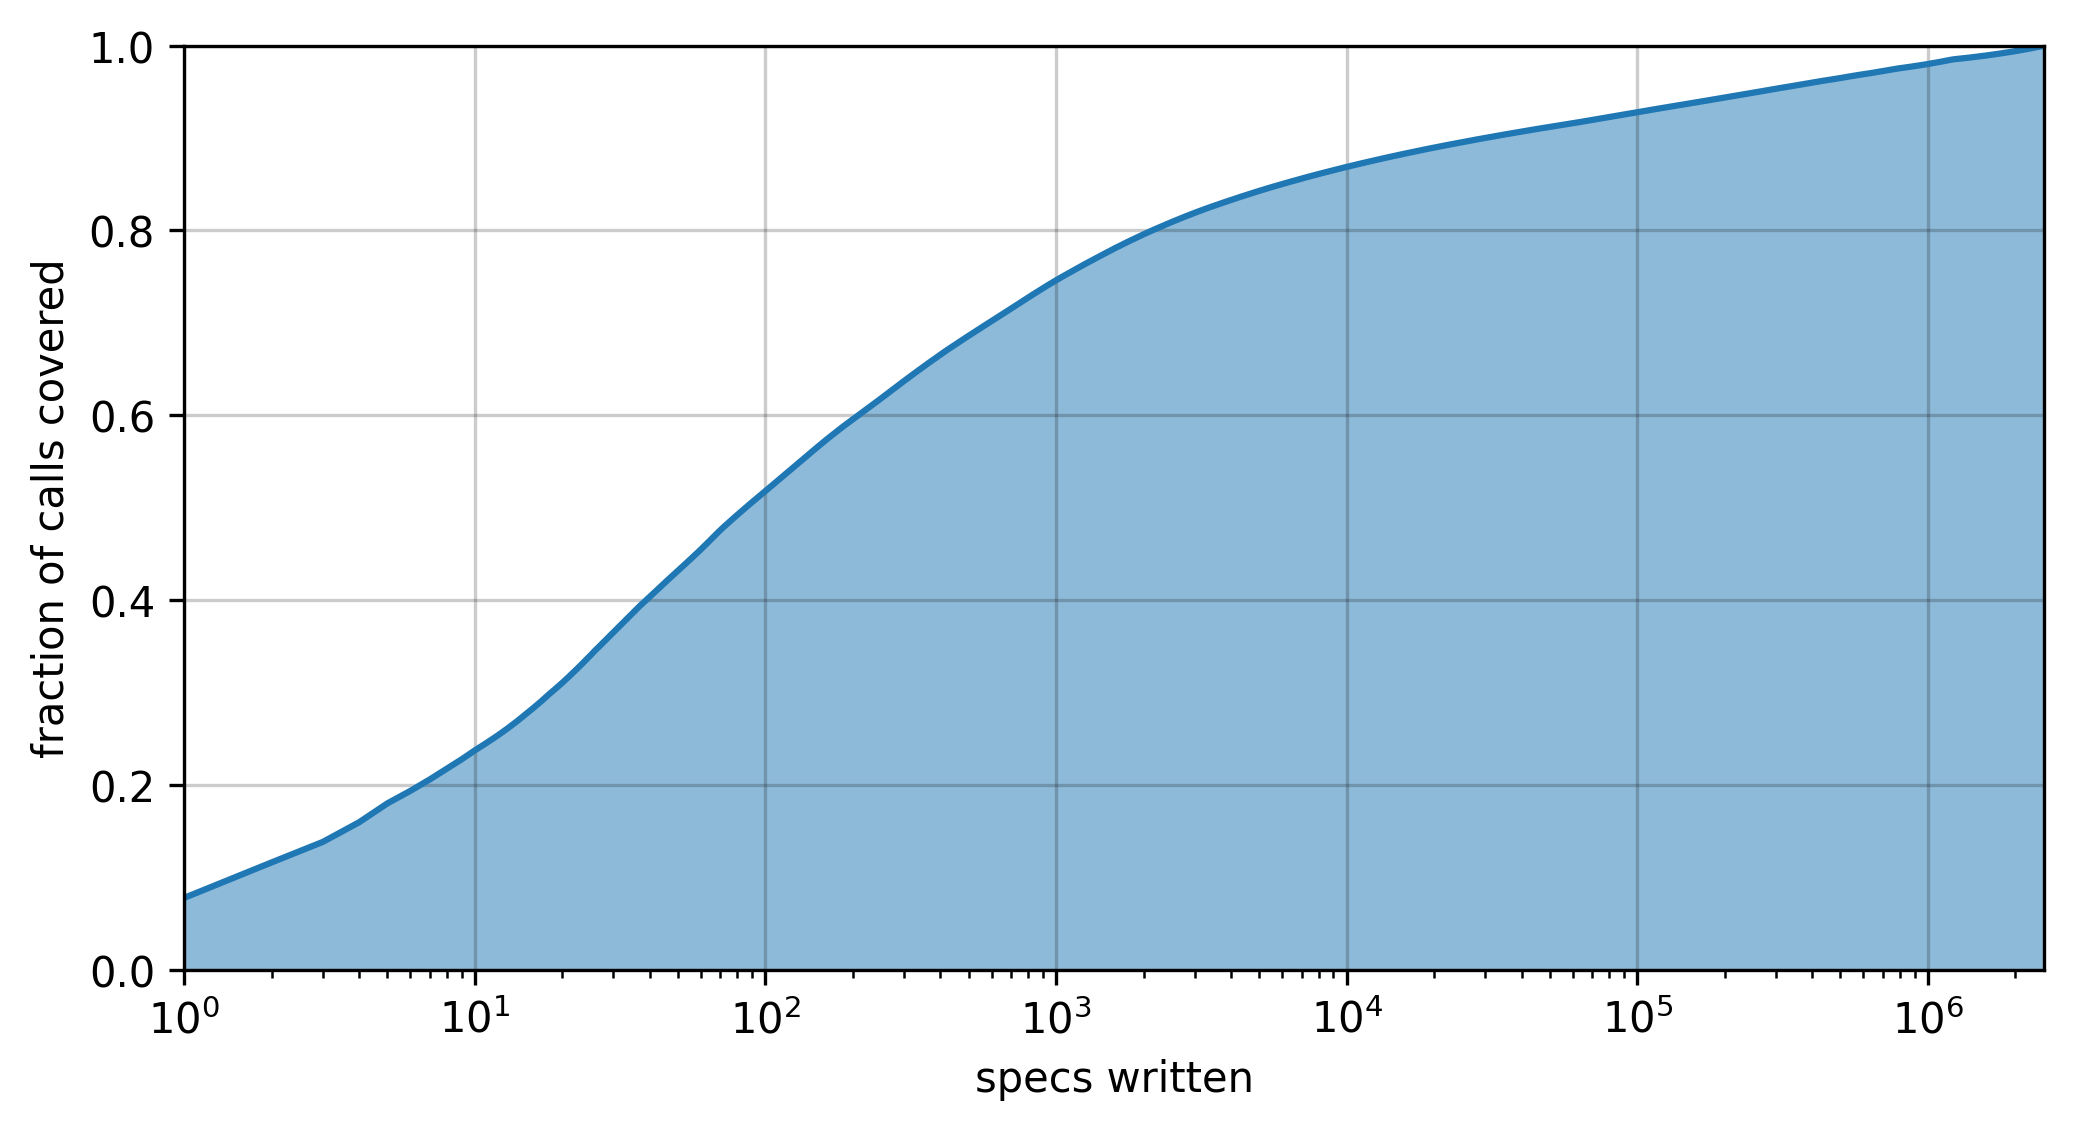

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(cumulative_counts.index, cumulative_counts["total"])
plt.grid(color=(0, 0, 0), alpha=0.2)
plt.fill_between(cumulative_counts.index, cumulative_counts["total"], alpha=0.5)
plt.xlim(1, cumulative_counts.index.max())
plt.ylim(0, 1)
plt.xscale('log')
plt.ylabel("fraction of calls covered")
plt.xlabel("specs written")
save_fig("coverage-by-specs")

In [11]:
by_target = sum_counts(all_calls, ['target', 'target_crate'])
by_target

,target,target_crate,count
0,core::cmp::PartialEq::eq,core,5122320
1,core::ops::deref::Deref::deref,core,4161020
2,core::clone::Clone::clone,core,3502722
3,core::ops::try_trait::Try::branch,core,3457142
4,core::ops::try_trait::FromResidual::from_residual,core,3457138
5,core::fmt::Formatter::write_str,core,3416666
6,core::default::Default::default,core,1900443
7,core::fmt::Arguments::new_v1,core,1851757
8,core::fmt::ArgumentV1::new_display,core,1774675
9,quote::__private::push_ident,quote,1180899


In [12]:
# details about disparity between commonly-called and rarely-called functions

counts = by_target["count"]

def print_details(mask):
	masked = counts[mask]
	print("Calls:", percentage_desc(masked.count(), counts.count()))
	print("Occurrences:", percentage_desc(masked.sum(), counts.sum()))

print("called < 10 times:")
print_details(counts < 10)
print()
print("called > 100k times:")
print_details(counts > 100_000)

called < 10 times:
Calls: 391898 / 446378 = 87.7951%
Occurrences: 795546 / 87060395 = 0.9138%

called > 100k times:
Calls: 101 / 446378 = 0.0226%
Occurrences: 63135495 / 87060395 = 72.5192%


In [13]:
# compute how many targets/calls it takes to cover the majority

cumulative_by_target = by_target.copy()
compute_totals(cumulative_by_target)

majority_by_target = len(cumulative_by_target[cumulative_by_target["total"] < 0.5]) + 1
print("targets:", percentage_desc(majority_by_target, len(cumulative_by_target)))
majority_by_call = len(cumulative_counts[cumulative_counts["total"] < 0.5]) + 1
print("calls:", percentage_desc(majority_by_call, len(cumulative_counts)))

targets: 27 / 446378 = 0.0060%
calls: 87 / 2511767 = 0.0035%


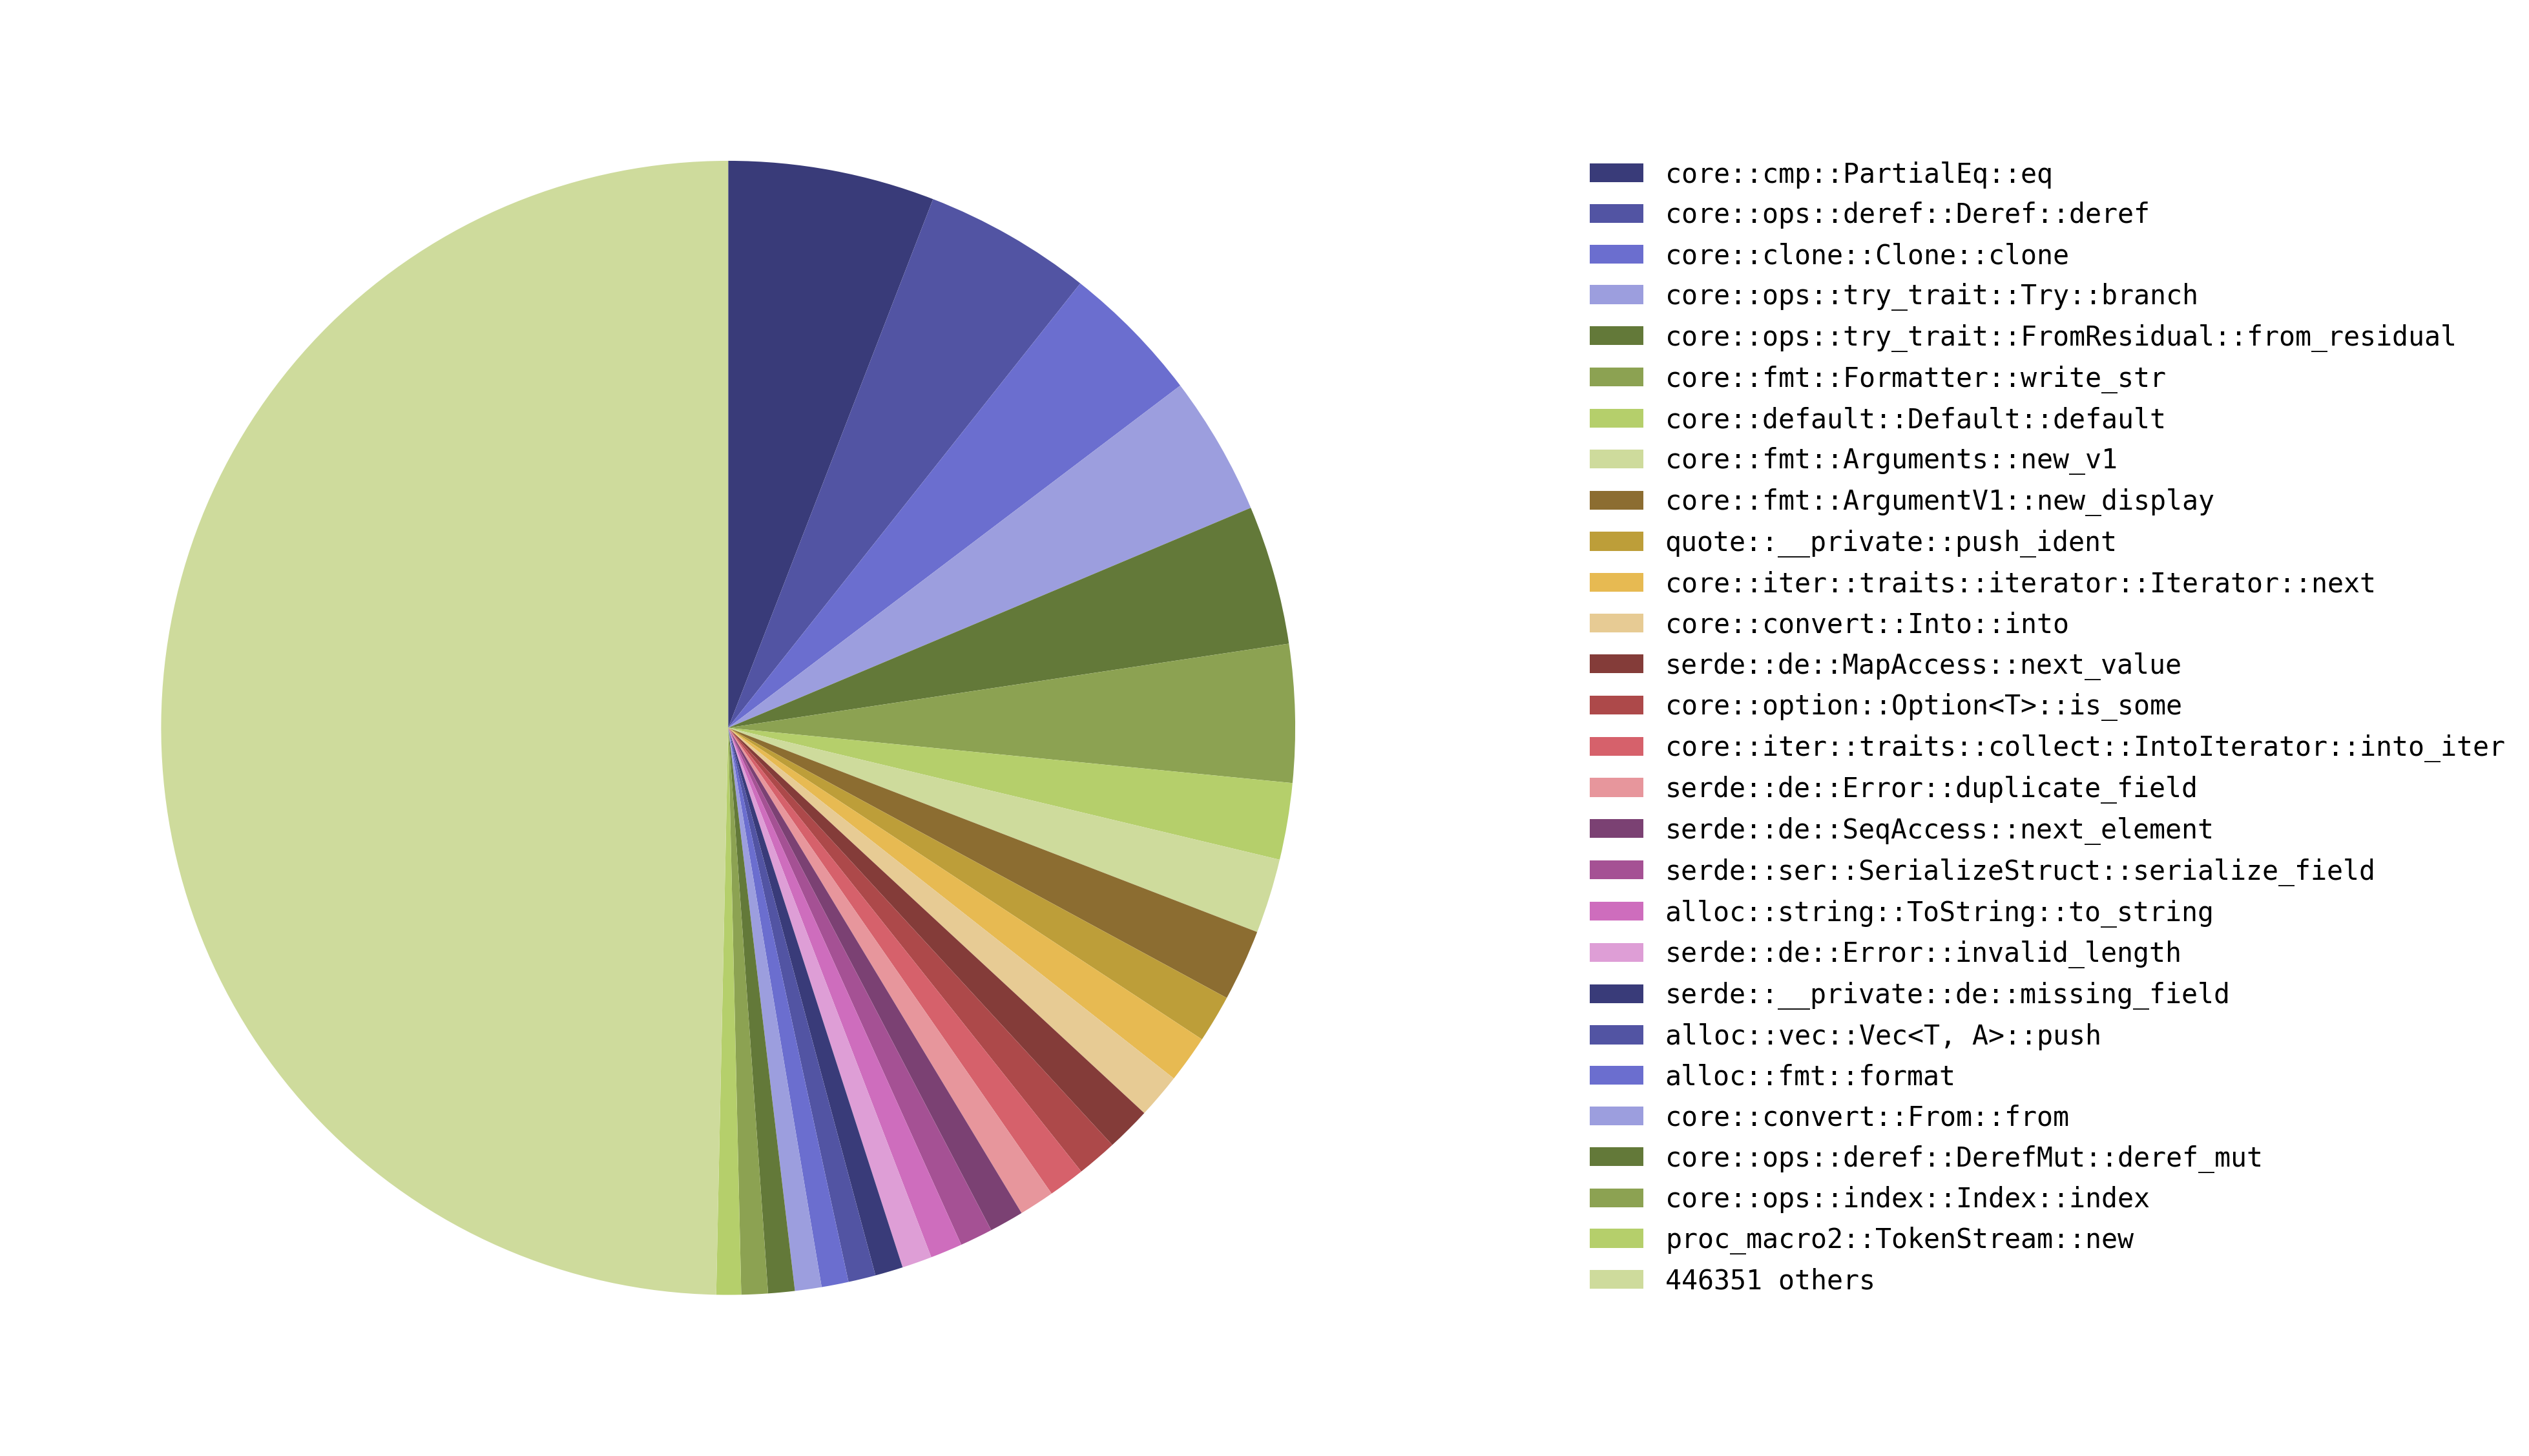

In [14]:
# illustrate the call disparity: how few functions it takes to cover the majority of calls
top_usage_counts = by_target.set_index('target')
top_usage_counts = cut_off_after_top(27, top_usage_counts)

fig, ax = plt.subplots(figsize=(19, 9.5))
colors = plt.cm.get_cmap('tab20b').colors
ax.pie(top_usage_counts['count'], startangle=90, counterclock=False, rotatelabels=False, colors=colors)
fig.legend(top_usage_counts.index, loc="center right", prop=monospace, frameon=False)
save_fig("call-disparity", bbox_inches="tight", pad_inches=-0.7)

## By Crate

In [15]:
# print full list of most popular targets in a single crate, for exporting

crate_filter = "core"
filtered = by_target[by_target['target_crate'] == crate_filter].reset_index(names='global_rank')
for i in range(min(100_000, len(filtered))):
	row = filtered.loc[i]
	print(f"{row['target']} - #{i + 1} (#{row['global_rank'] + 1} globally, {row['count']}x)")

core::cmp::PartialEq::eq - #1 (#1 globally, 5122320x)
core::ops::deref::Deref::deref - #2 (#2 globally, 4161020x)
core::clone::Clone::clone - #3 (#3 globally, 3502722x)
core::ops::try_trait::Try::branch - #4 (#4 globally, 3457142x)
core::ops::try_trait::FromResidual::from_residual - #5 (#5 globally, 3457138x)
core::fmt::Formatter::write_str - #6 (#6 globally, 3416666x)
core::default::Default::default - #7 (#7 globally, 1900443x)
core::fmt::Arguments::new_v1 - #8 (#8 globally, 1851757x)
core::fmt::ArgumentV1::new_display - #9 (#9 globally, 1774675x)
core::iter::traits::iterator::Iterator::next - #10 (#11 globally, 1177558x)
core::convert::Into::into - #11 (#12 globally, 1112335x)
core::option::Option<T>::is_some - #12 (#14 globally, 998312x)
core::iter::traits::collect::IntoIterator::into_iter - #13 (#15 globally, 903477x)
core::convert::From::from - #14 (#24 globally, 659319x)
core::ops::deref::DerefMut::deref_mut - #15 (#25 globally, 659261x)
core::ops::index::Index::index - #16 (#26 

In [16]:
by_crate = sum_counts(all_calls, ['target_crate']).set_index('target_crate')
by_crate

,count
target_crate,
core,53860887
serde,7596756
alloc,5584314
quote,3728109
std,1791127
clap,1425205
tracing_core,1180971
proc_macro2,764877
log,641517


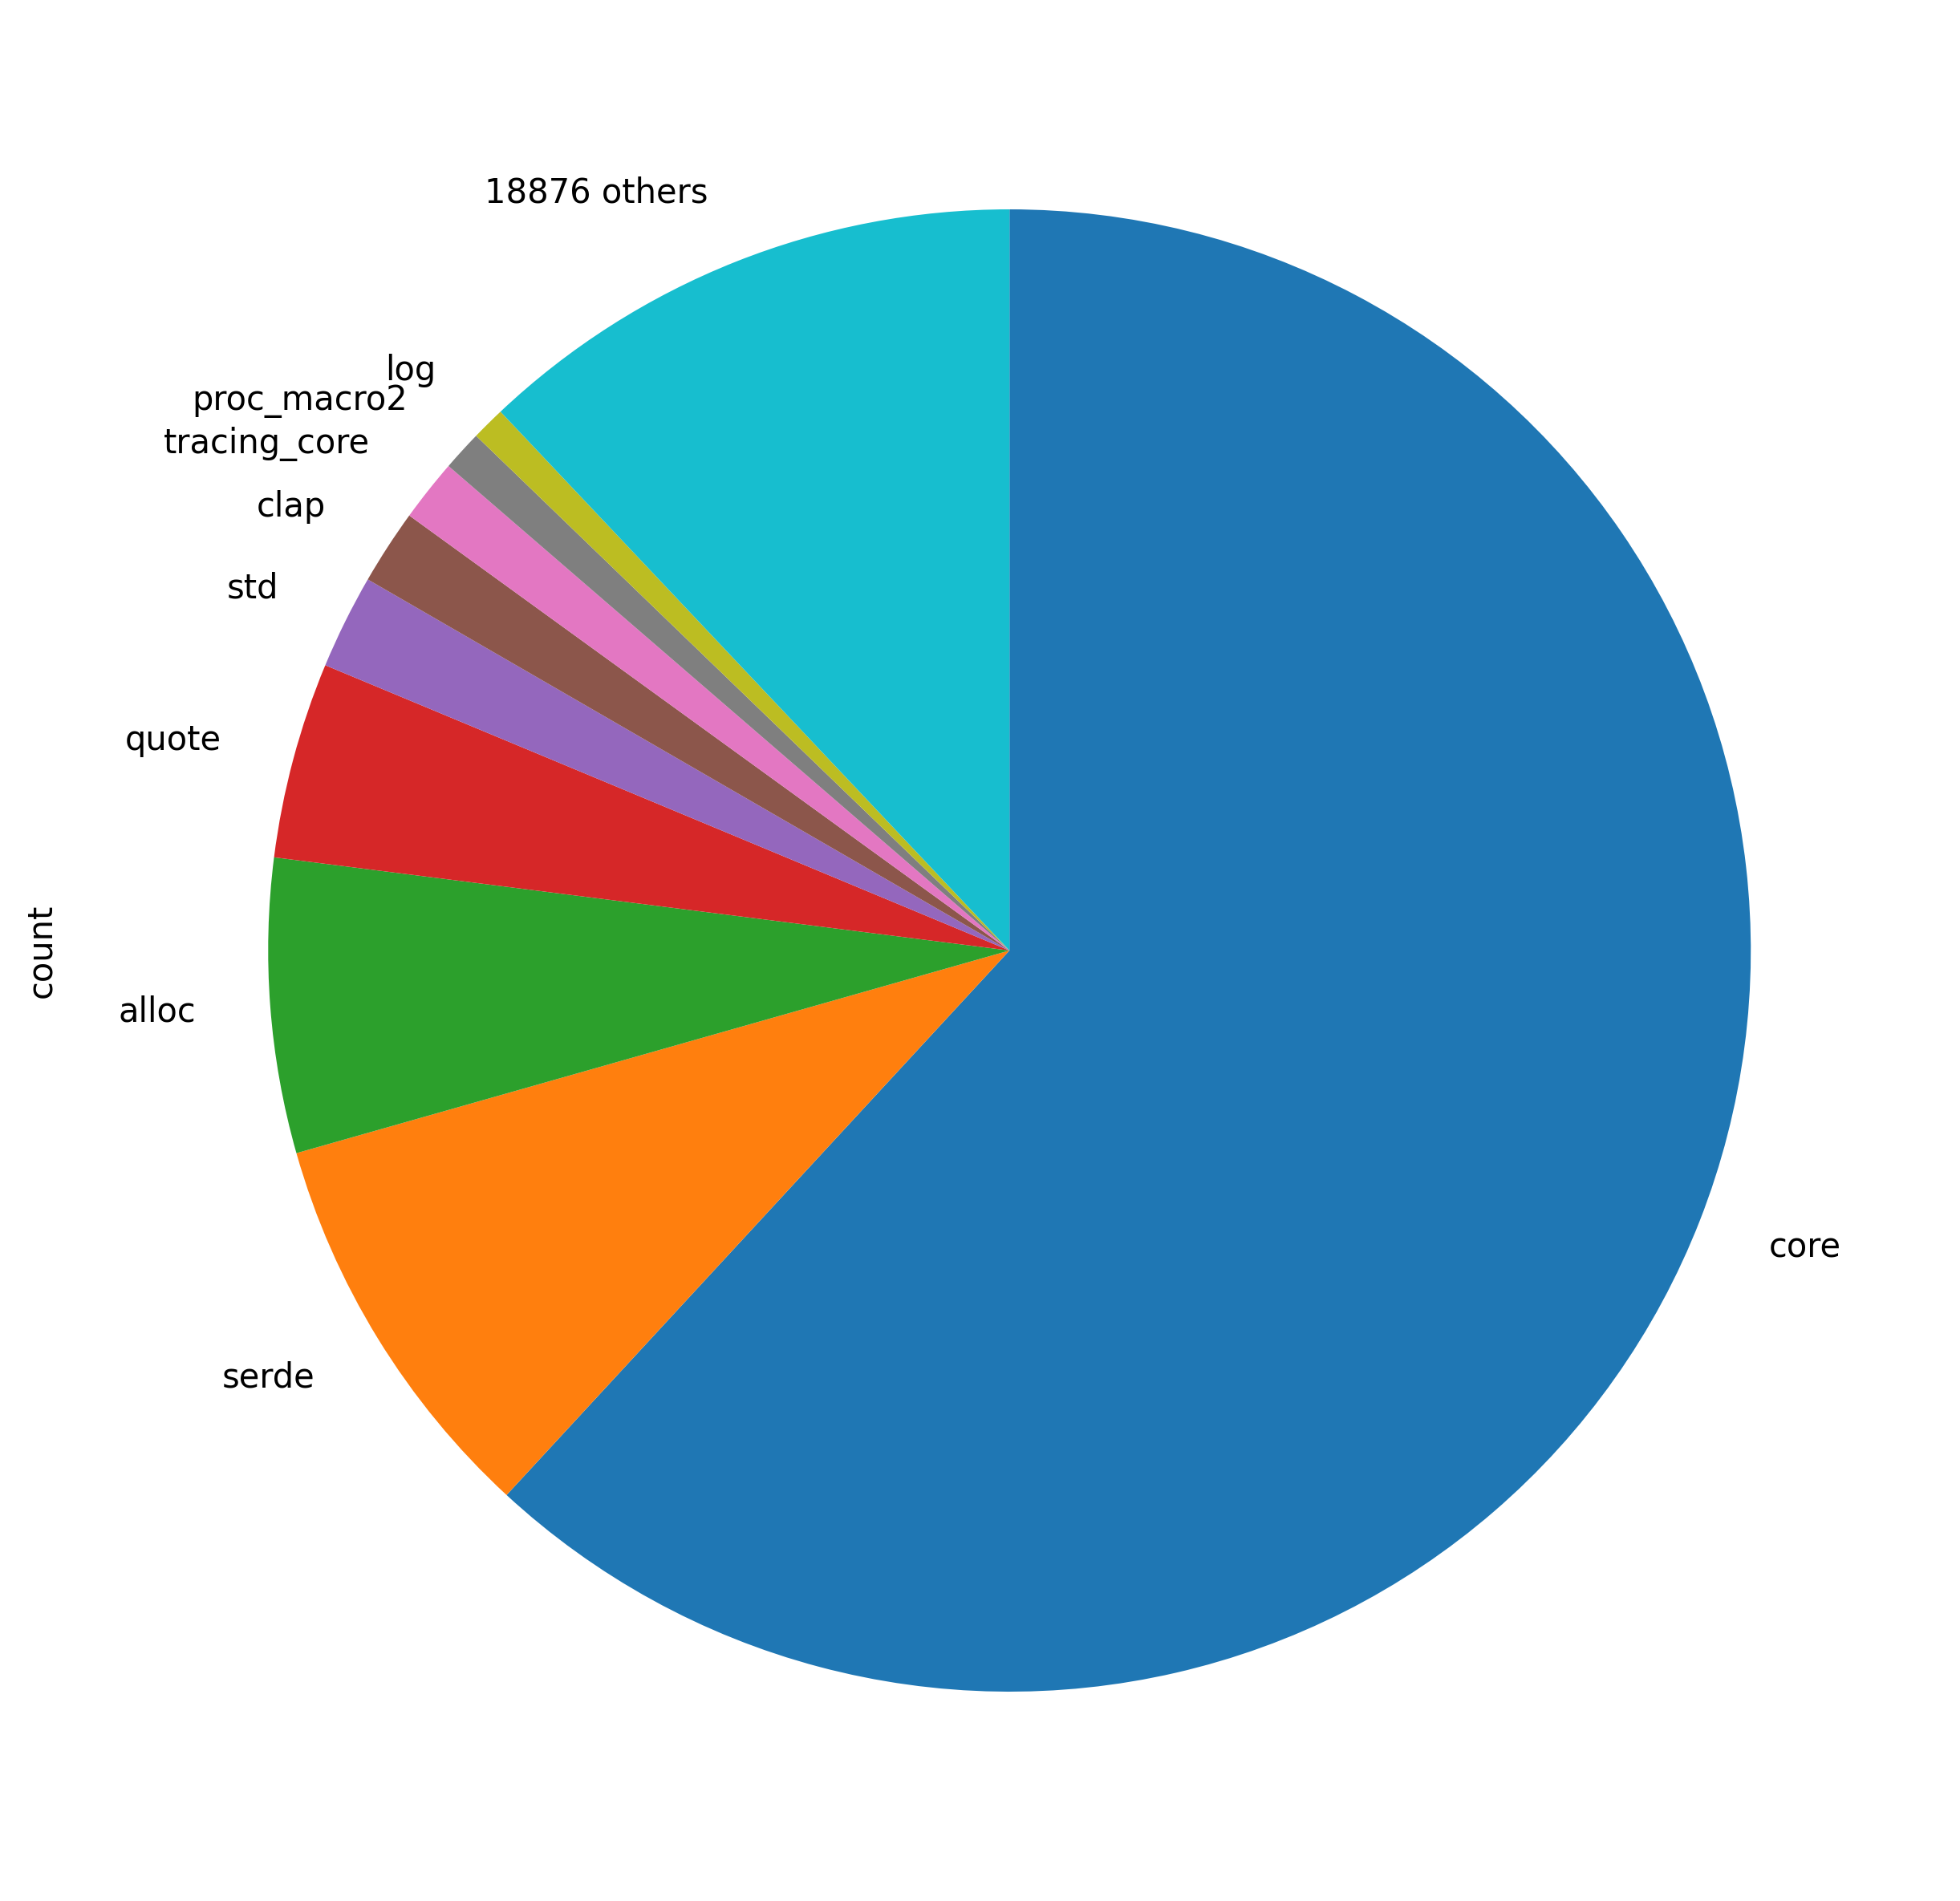

In [17]:
cut_off_after_top(9, by_crate).plot(
	kind='pie',
	y='count',
	legend=False,
	startangle=90, counterclock=False,
	figsize=(21, 10),
)
plt.show()

## Macros

In [18]:
macro_counts = sum_counts(all_calls, ['macro']).copy()
print(macro_counts.loc[1:, 'count'].sum().item(), "total")
macro_counts[:20]

41554923 total


,macro,count
0,,45505472
1,serde_derive::Deserialize,8403994
2,quote::quote,4020577
3,core::fmt::macros::Debug,4019790
4,core::clone::Clone,2145961
5,serde_derive::Serialize,2130288
6,alloc::macros::format,1970558
7,core::cmp::PartialEq,1270583
8,prost_derive::Message,1129711
9,core::macros::write,1125126


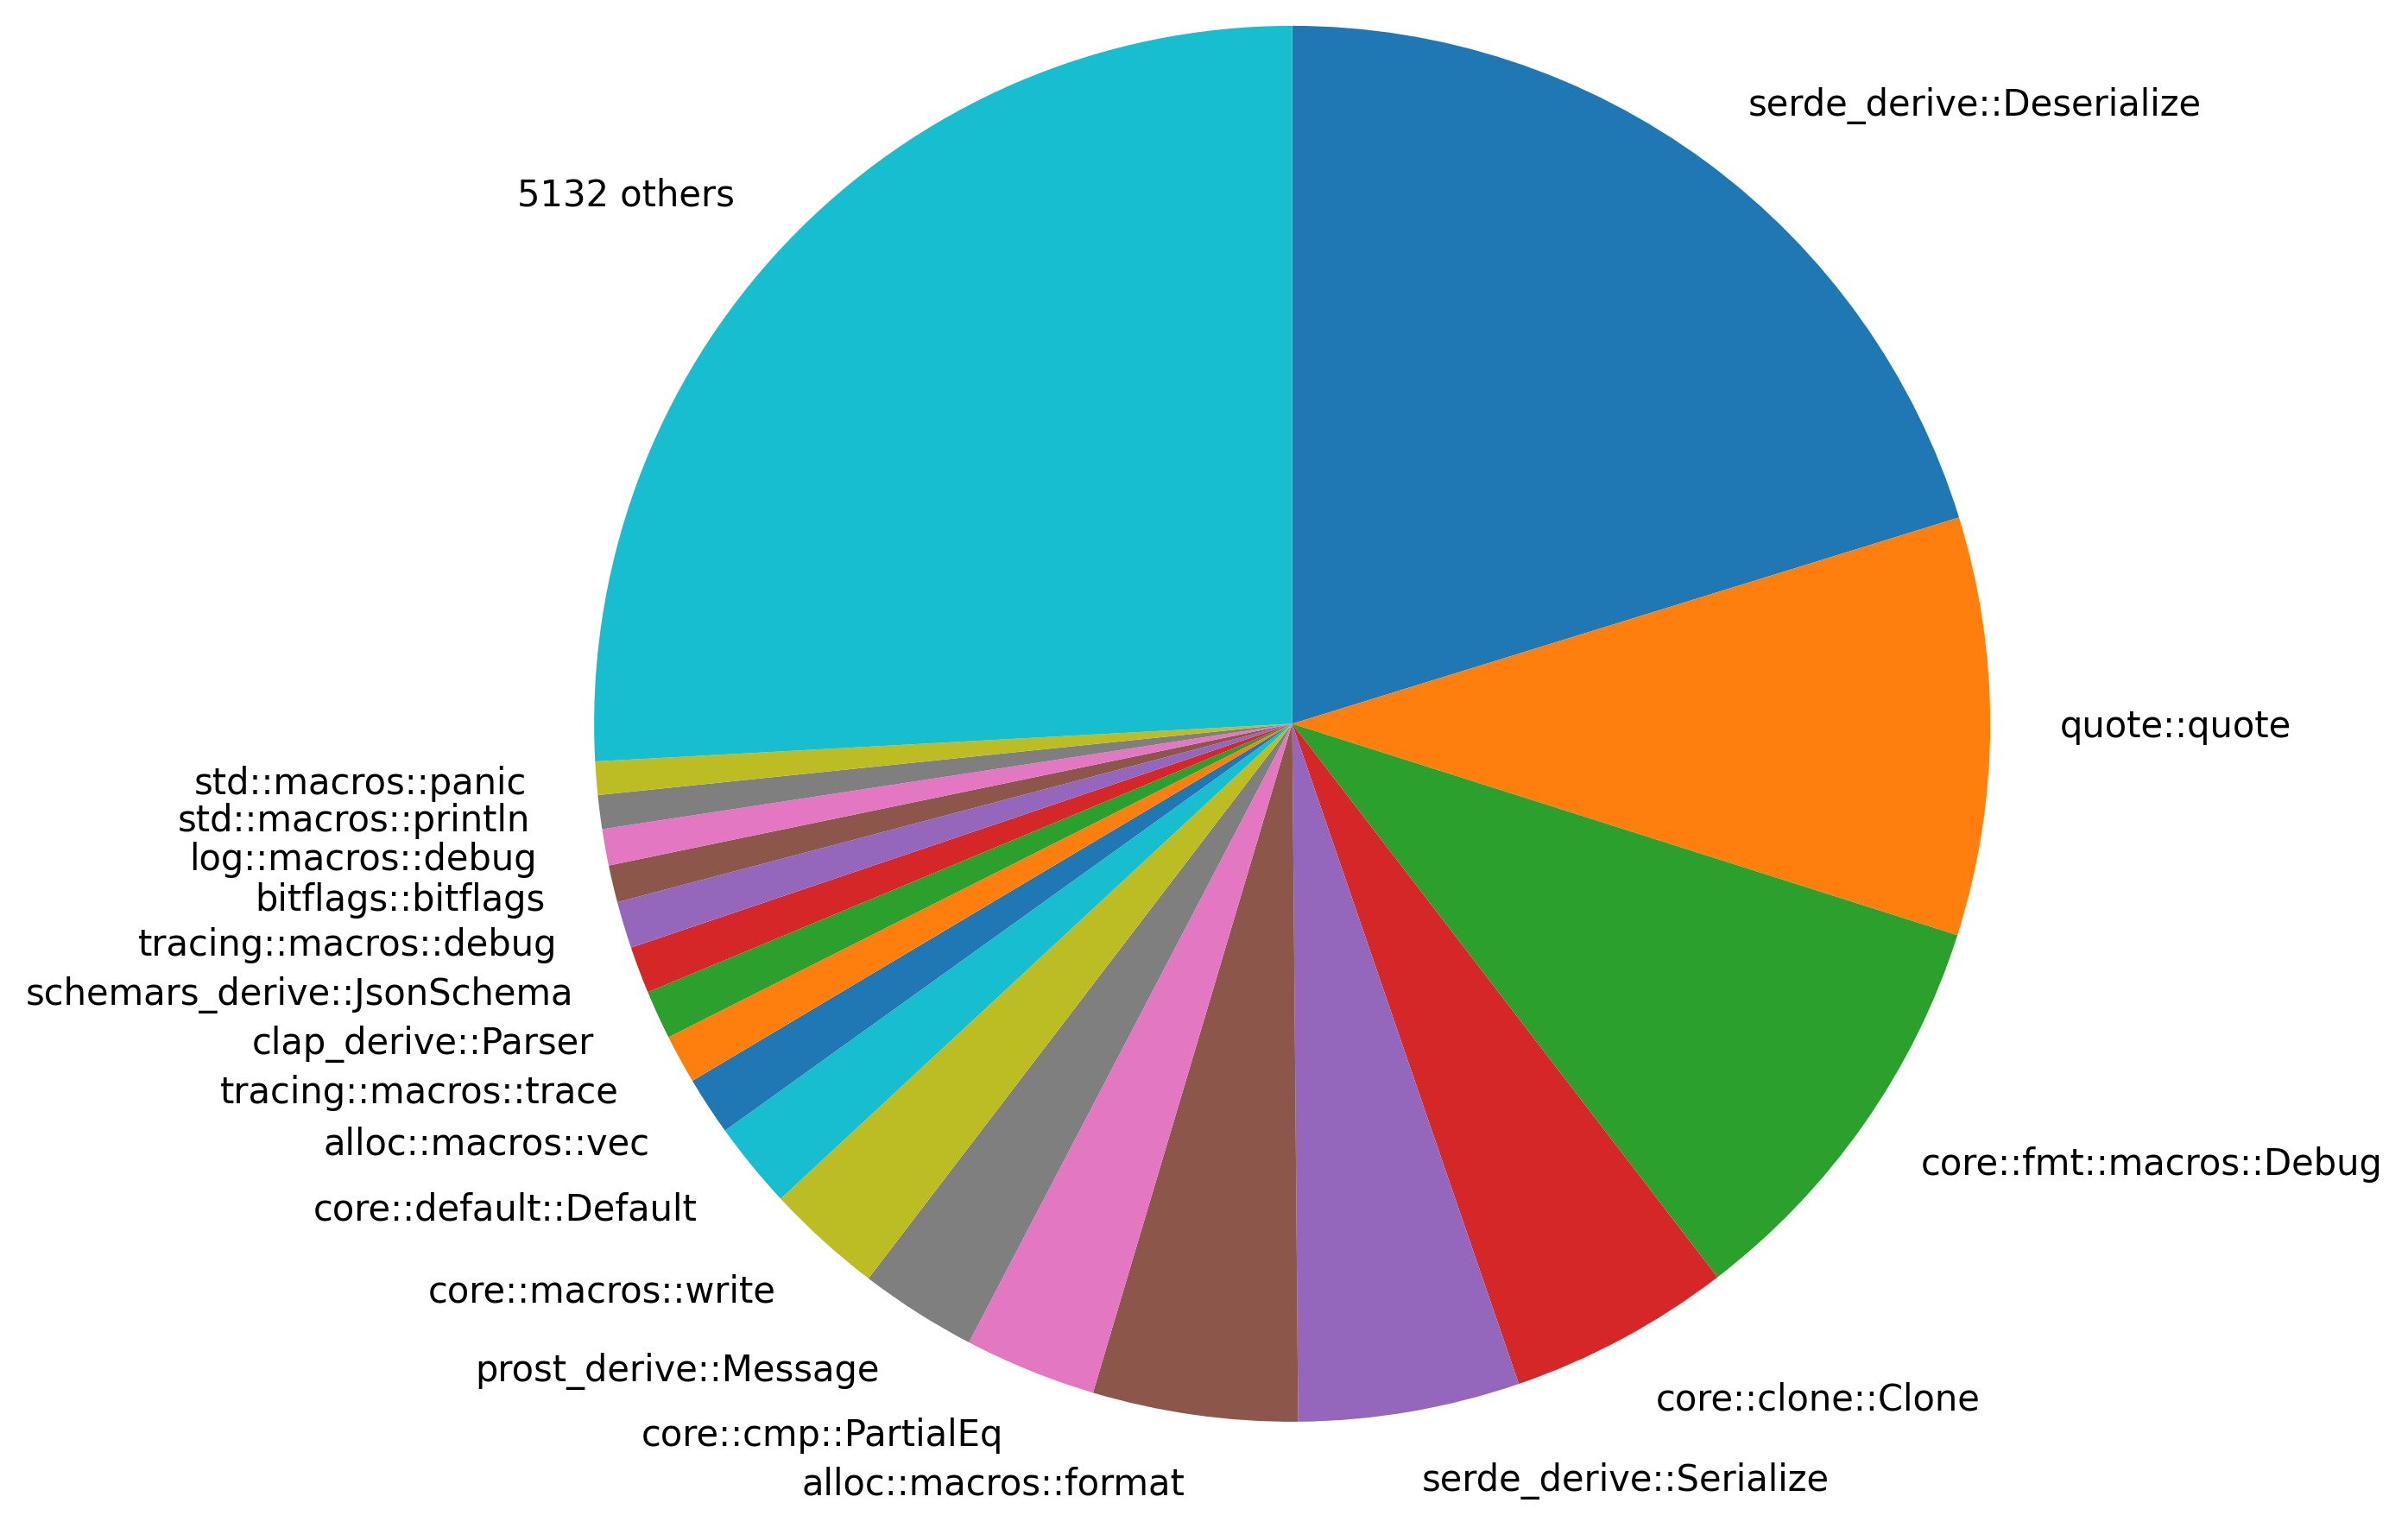

In [19]:
top_macro_counts = macro_counts.copy()
top_macro_counts.set_index('macro', inplace=True)
top_macro_counts.drop([""], inplace=True)

data = cut_off_after_top(19, top_macro_counts)
plt.pie(data['count'], labels=data.index, startangle=90, counterclock=False, radius=3.5)
save_and_resize_fig("macros.png", 10, 6.5)

---

# Overall Progress

In [20]:
progress_csv = (
    pd.read_csv(
        "spec_progress.csv",
        header=0,
        index_col=False,
        names=["receiver", "target", "reason"],
        dtype=str,
        comment="#",
    )
    .dropna(how="all")
	.fillna("")
)
progress_csv

,receiver,target,reason
0,core::result::Result,core::ops::try_trait::Try::branch,
1,core::result::Result,core::ops::try_trait::FromResidual::from_residual,
2,core::option::Option,core::ops::try_trait::Try::branch,
3,core::option::Option,core::ops::try_trait::FromResidual::from_residual,
4,*,core::clone::Clone::clone,
5,*,core::convert::From::from,convert
6,*,core::convert::Into::into,convert
7,*,core::default::Default::default,default
8,,core::option::Option<T>::is_some,
9,,core::option::Option<T>::is_none,


In [42]:
# methods to query progress

progress = {}
used_progress = set()

for (receiver, call_target, reason) in progress_csv.values:
	if not call_target: continue
	key = (receiver, call_target)
	if key in progress:
		raise Exception(f"Duplicate entry for {key}")
	progress[key] = reason

def _get_progress(key: Tuple[str, str]) -> Optional[str]:
	result = progress[key]
	used_progress.add(key)
	return result
	

# if incomplete, returns string listing future features necessary for complete specification
def progress_for(receiver: str, call_target: str, macro: str) -> str:
	try:
		return _get_progress((receiver, call_target)) or "complete"
	except KeyError:
		if receiver.startswith("impl") or receiver.isupper():
			return "generic"
		try:
			return _get_progress(("*", call_target)) or "complete"
		except KeyError:
			if macro:
				return "macro"
			else:
				return "unknown"

def get_progress(row) -> str:
	return progress_for(row['receiver'], row['target'], row['macro'])

In [43]:
counts_with_progress = sum_counts(all_calls, ['receiver', 'target', 'macro'])
counts_with_progress["progress"] = counts_with_progress.apply(get_progress, axis=1)
counts_with_progress = sum_counts(counts_with_progress, ['receiver', 'target', 'progress'])
counts_with_progress.loc[:10_000].to_csv("counts_with_progress.csv", index=False)
counts_with_progress

,receiver,target,progress,count
0,,core::fmt::Formatter::write_str,formatting,3416666
1,core::result::Result,core::ops::try_trait::Try::branch,complete,3349092
2,core::result::Result,core::ops::try_trait::FromResidual::from_residual,complete,3341551
3,str,core::cmp::PartialEq::eq,strings,1932084
4,,core::fmt::Arguments::new_v1,formatting,1851757
5,,core::fmt::ArgumentV1::new_display,formatting,1774675
6,,quote::__private::push_ident,macro,1180899
7,__A,serde::de::MapAccess::next_value,generic,1078597
8,,core::option::Option<T>::is_some,complete,998312
9,core::option::Option,core::clone::Clone::clone,complete,888244


In [44]:
progress_csv_with_usage = progress_csv.copy()
progress_csv_with_usage["used"] = progress_csv_with_usage.apply(lambda row: (row["receiver"], row["target"]) in used_progress, axis=1)
progress_csv_with_usage.to_csv("spec_progress_with_usage.csv", index=False)

In [45]:
progress_tally = sum_counts(counts_with_progress, ["progress"])
progress_tally.set_index('progress', inplace=True)
print(f"total: {progress_tally['count'].sum()}")
progress_tally

total: 87060395


,count
progress,
macro,18102086
unknown,16325881
complete,14319962
formatting,10680202
issue_1221,7071330
generic,5899394
iterators,3540938
strings,2361165
calls,2013703


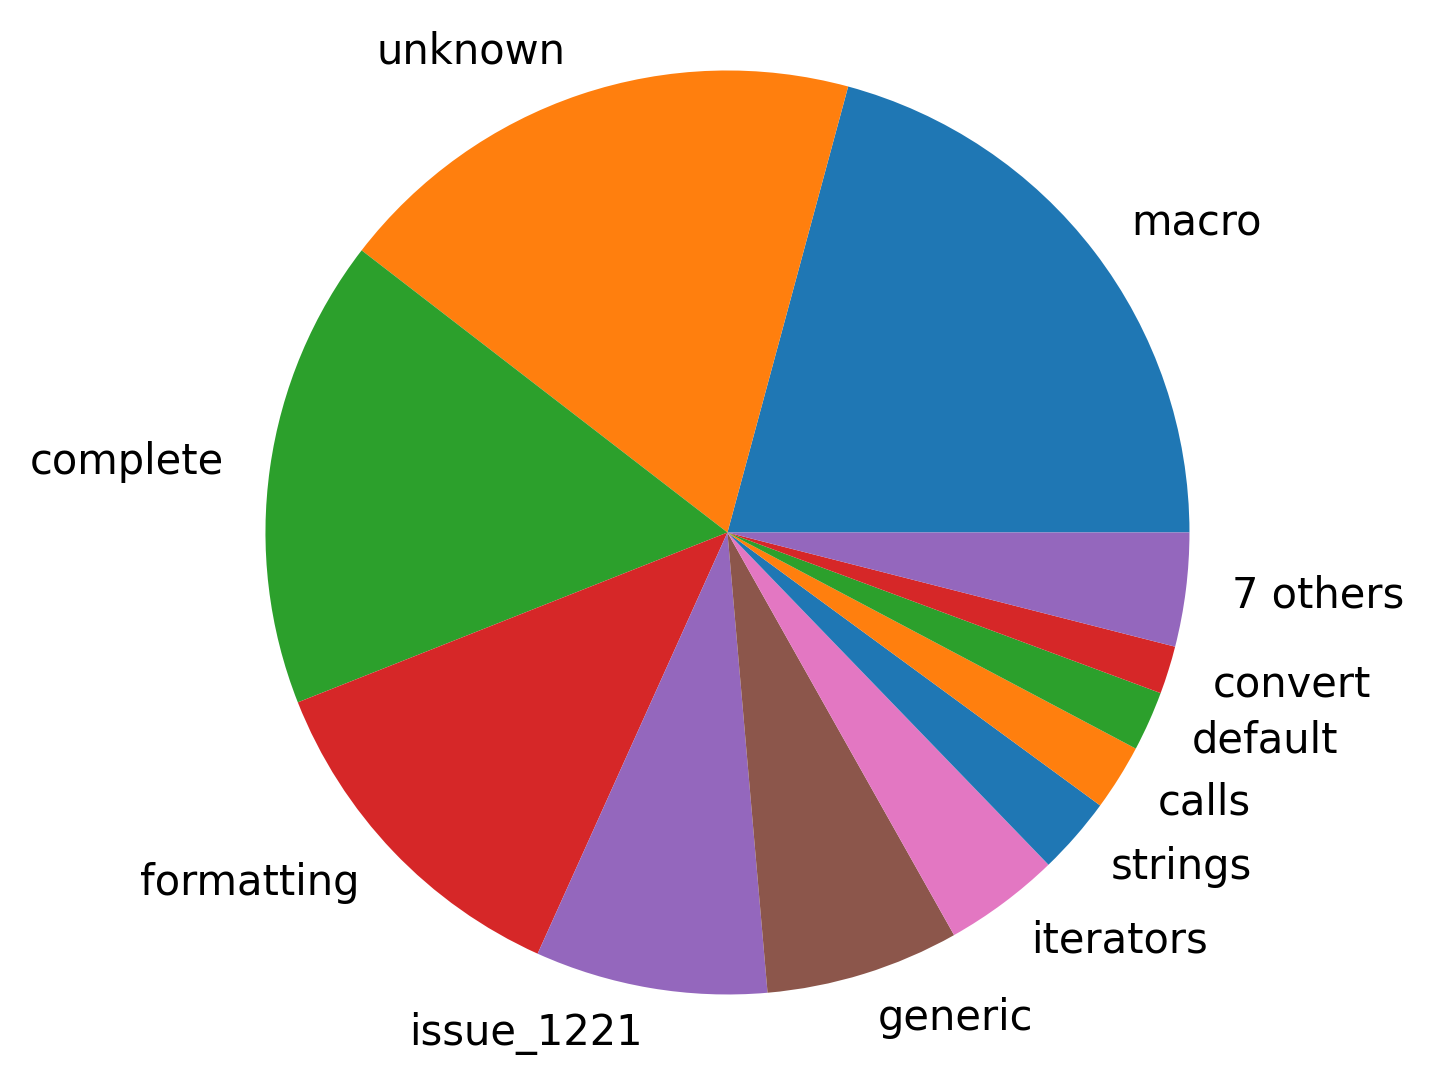

In [46]:
# plot progress by categorization of each call

cut_off_after_top(11, progress_tally).plot(
	kind='pie',
	y='count', ylabel='',
	legend=False,
	colors=plt.get_cmap('tab10').colors[:7],
	radius=2,
)
save_and_resize_fig("progress-all", 6, 3.6)

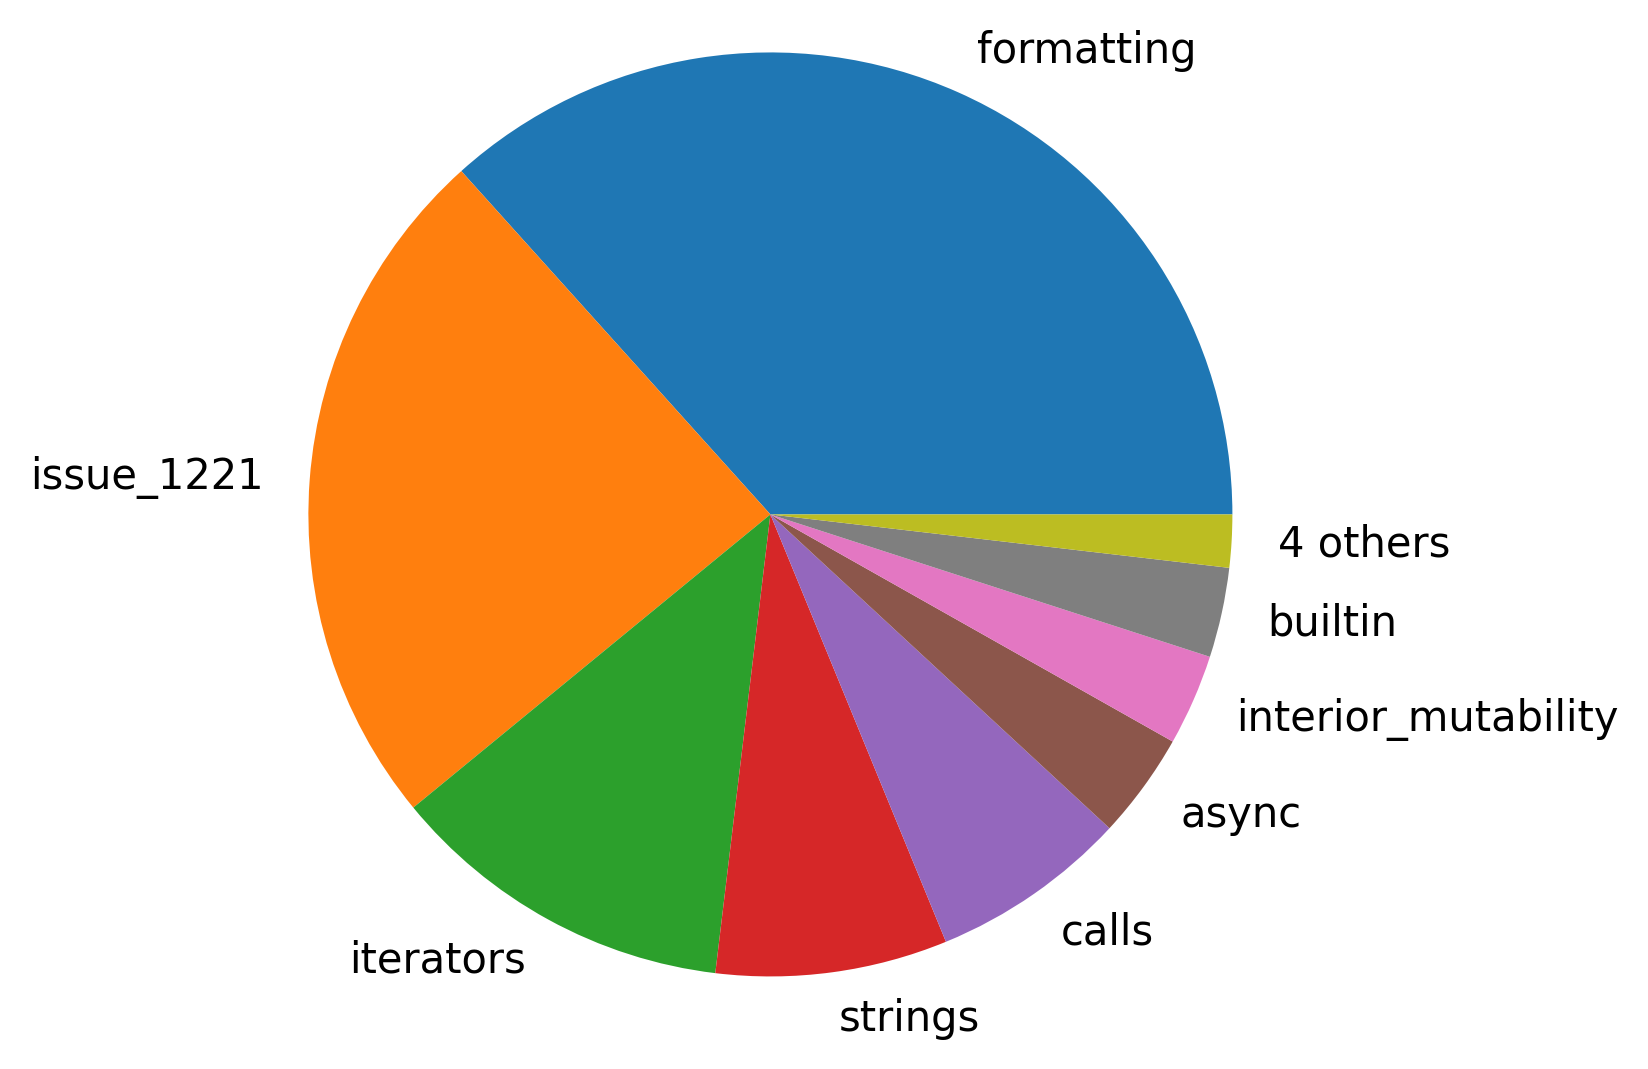

In [47]:
specifiable_tally = progress_tally.drop(["unknown", "complete", "macro", "generic", "default", "convert"])
cut_off_after_top(8, specifiable_tally).plot(
	kind='pie',
	y='count', ylabel='',
	legend=False,
	radius=2,
)
save_and_resize_fig("progress-specifiable", 6, 3.6)

---

# Specific Targets

## `From`/`Into`

In [48]:
from_calls = all_calls[all_calls['target'] == 'core::convert::From::from']
from_counts = sum_counts(from_calls, ['target_type_generics', 'receiver', 'receiver_generics', 'macro'])
print("from() calls:", from_counts["count"].sum())

from_counts = from_counts.rename(columns={
	'target_type_generics': 'source',
	'receiver': 'target',
	'receiver_generics': 'target_generics',
})
from_counts['source_generics'] = ""

into_calls = all_calls[all_calls['target'] == 'core::convert::Into::into']
into_counts = sum_counts(into_calls, ['target_type_generics', 'receiver', 'receiver_generics', 'macro'])
print("into() calls:", into_counts["count"].sum())

into_counts = into_counts.rename(columns={
	'target_type_generics': 'target',
	'receiver': 'source',
	'receiver_generics': 'source_generics',
})
into_counts['target_generics'] = ""

all_conversions = sum_counts(pd.concat([from_counts, into_counts]), ['source', 'source_generics', 'target', 'target_generics', 'macro'])

conversions = all_conversions.copy()
print("all calls:", conversions["count"].sum())
conversions.drop(conversions[conversions['source'].str.startswith('impl ')].index, inplace=True)
conversions.drop(conversions[conversions['source'].str.isupper()].index, inplace=True)
print("calls excl. known unspecifiable:", conversions["count"].sum())
conversions.drop(conversions[conversions['macro'] != ''].index, inplace=True)
conversions.drop(columns=['macro'], inplace=True)
print("calls also excl. macros:", conversions['count'].sum())
conversions.reset_index(drop=True, inplace=True)

from() calls: 659319
into() calls: 1112335
all calls: 1771654
calls excl. known unspecifiable: 1460081
calls also excl. macros: 1110818


In [49]:
std_crate_type_regex = r'^(core|std|alloc)::|^[^:]+$'
std_conversions = conversions.loc[conversions['source'].str.match(std_crate_type_regex) & conversions['target'].str.match(std_crate_type_regex)]
print("conversions only involving std types:", percentage_desc(std_conversions["count"].sum(), conversions["count"].sum()))

conversions only involving std types: 314869 / 1110818 = 28.3457%


In [50]:
# load & apply progress data

known_conversions = {}

with open("conversions.txt") as f:
	for line in f.readlines():
		(source, targets) = line.strip().split(" => ")
		known_conversions.setdefault(source, set())
		known_conversions[source].update(targets.split(" "))

def conversion_status(source, target) -> str:
	if source == target:
		return "identity"
	try:
		if target in known_conversions[source]:
			return "specified"
	except KeyError:
		return "unspecified"
	return "unspecified"

conversions['status'] = conversions.apply(lambda row: conversion_status(row['source'], row['target']), axis=1)
conversions.loc[0, 'status'] = "issue_1221"
conversions[:15]

,source,source_generics,target,target_generics,count,status
0,&str,,alloc::string::String,,147264,issue_1221
1,proc_macro2::TokenStream,,proc_macro::TokenStream,,16328,unspecified
2,aws_smithy_types::error::Error,,alloc::boxed::Box<dyn std::error::Error + std:...,,12328,unspecified
3,aws_types::region::Region,,aws_types::region::SigningRegion,,12263,unspecified
4,&str,,alloc::borrow::Cow<str>,,11818,unspecified
5,alloc::string::String,,hyper::body::body::Body,,11656,unspecified
6,[f32],,geometric_algebra::simd::Simd32x4,,9666,unspecified
7,aws_smithy_http::body::SdkBody,,aws_smithy_http::body::SdkBody,,9320,identity
8,alloc::string::String,,aws_smithy_http::body::SdkBody,,9213,unspecified
9,f32,,geometric_algebra::simd::Simd32x4,,9016,unspecified


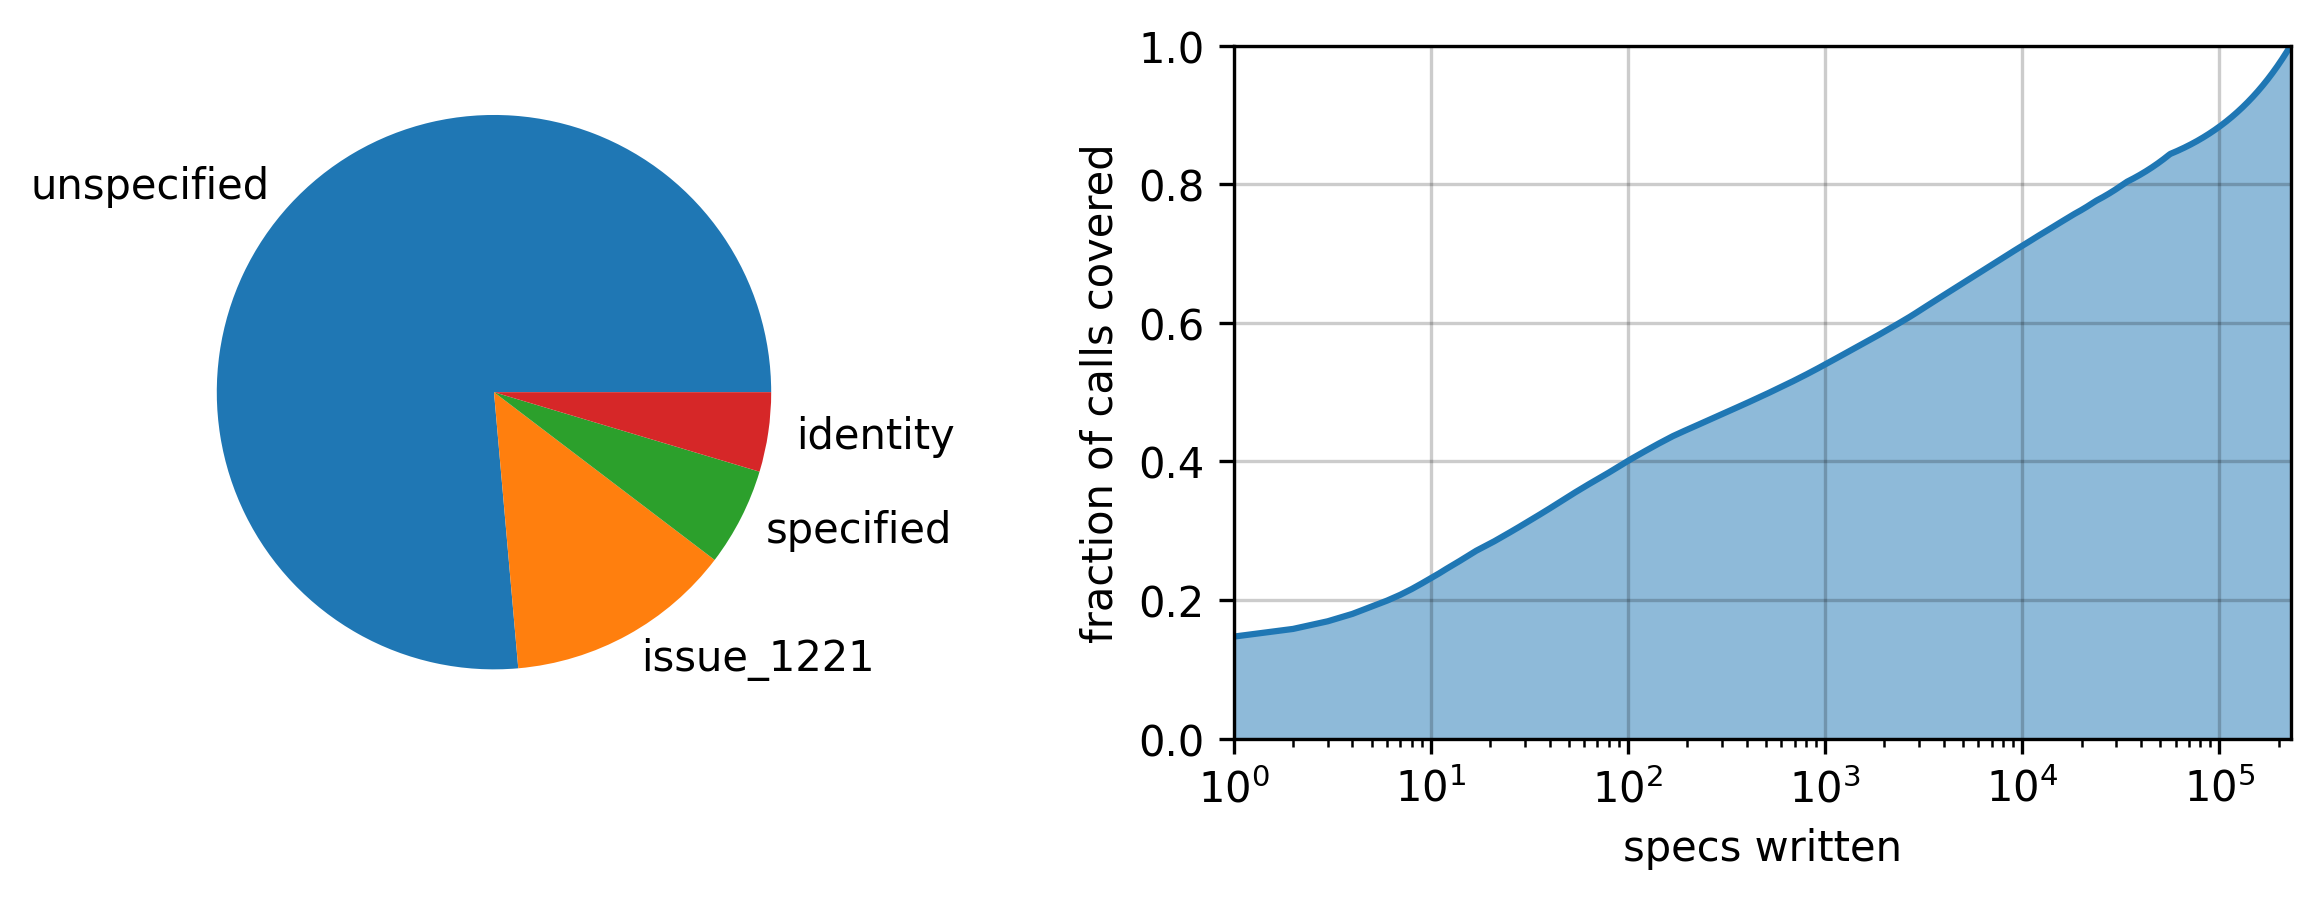

In [51]:
# graph progress & distribution

totals = conversions['count'].cumsum() / conversions['count'].sum()

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 2, 1)
by_status = sum_counts(conversions, ['status']).set_index('status')
ax.pie(by_status['count'], labels=by_status.index)

ax = fig.add_subplot(1, 2, 2)
ax.grid(color=(0, 0, 0), alpha=0.2)
ax.plot(conversions.index, totals)
ax.fill_between(conversions.index, totals, alpha=0.5)
plt.xlim(1, conversions.index.max())
plt.ylim(0, 1)
plt.xscale('log')
plt.ylabel("fraction of calls covered")
plt.xlabel("specs written")
save_fig("convert", bbox_inches='tight')

## `transmute`

In [52]:
transmute_calls = all_calls[all_calls['target'] == 'core::intrinsics::foreign::transmute']
transmute_counts = sum_counts(transmute_calls, ['target_function_generics'])
transmute_counts[:20]

,target_function_generics,count
0,"u32, u32",33369
1,"*const std::ffi::c_void, $fn",21269
2,"*const (), $fn",4219
3,"*mut u32, *mut u32",3178
4,"(), ()",2562
5,"u64, u64",2531
6,"u8, u8",2397
7,"$fn, $fn",2392
8,"*const libc::c_void, $fn",1628
9,"*const __gl_imports::libc::c_void, $fn",1625


## `size_of`

In [53]:
size_of_calls = all_calls[all_calls['target'] == 'core::mem::size_of']
size_of_counts = sum_counts(size_of_calls.rename(columns={'target_function_generics': 'type'}), ['type'])
size_of_counts.set_index('type', inplace=True)

print(f"total: {size_of_counts['count'].sum()}")
size_of_counts.drop(size_of_counts[size_of_counts.index.str.isupper()].index, inplace=True)
size_of_counts.drop('Self', inplace=True)
print(f"total excl. known unspecifiable: {size_of_counts['count'].sum()}")

with open("known_sizes.txt") as f:
	known_size_types = set(line.strip() for line in f.readlines())

size_of_counts['specified'] = size_of_counts.index.isin(known_size_types)
known = size_of_counts[size_of_counts['specified']]['count'].sum()
total = size_of_counts['count'].sum()
print("size_of calls specified:", percentage_desc(known, total))

total: 100635
total excl. known unspecifiable: 89005
size_of calls specified: 66601 / 89005 = 74.8284%


In [54]:
size_of_counts[:20]

,count,specified
type,,
u32,9920,True
u8,8048,True
u64,7369,True
u16,6046,True
usize,4987,True
i32,4974,True
i64,3978,True
i16,3703,True
u128,3348,True


In [55]:
align_of_calls = all_calls[all_calls['target'] == 'core::mem::align_of']
align_of_counts = sum_counts(align_of_calls.rename(columns={'target_function_generics': 'type'}), ['type'])
align_of_counts.set_index('type', inplace=True)

print(f"total: {align_of_counts['count'].sum()}")
align_of_counts.drop(align_of_counts[align_of_counts.index.str.isupper()].index, inplace=True)
align_of_counts.drop('Self', inplace=True)
print(f"total excl. known unspecifiable: {align_of_counts['count'].sum()}")

align_of_counts['specified'] = align_of_counts.index.isin(known_size_types)
known = align_of_counts[align_of_counts['specified']]['count'].sum()
total = align_of_counts['count'].sum()
print("align_of calls specified:", percentage_desc(known, total))

total: 8301
total excl. known unspecifiable: 6510
align_of calls specified: 1474 / 6510 = 22.6421%


In [56]:
align_of_counts[align_of_counts.index.str.startswith('sixtyfps')]['count'].sum()
align_of_counts[:20]

,count,specified
type,,
sixtyfps_corelib::properties::Property<f32>,254,False
i_slint_core::properties::Property<i_slint_core::layout::LayoutInfo>,207,False
usize,190,True
"i_slint_core::properties::Property<euclid::length::Length<f32, i_slint_core::lengths::LogicalPx>>",138,False
u32,129,True
i32,123,True
f32,119,True
i_slint_core::properties::Property<i_slint_core::sharedvector::SharedVector<f32>>,119,False
core::cell::Cell<u32>,116,False


## `Default`

In [57]:
with open("known_defaults.txt") as f:
	known_default_types = set(line.strip() for line in f.readlines())

default_calls = all_calls[all_calls['target'] == 'core::default::Default::default']
default_counts = sum_counts(default_calls, ['receiver'])

print(f"total: {default_counts['count'].sum()}")
default_counts.drop(default_counts[default_counts['receiver'].str.isupper()].index, inplace=True)
default_counts.reset_index(drop=True, inplace=True)
total = default_counts['count'].sum()
print(f"total excl. known unspecifiable: {total}")

std_total = default_counts[default_counts['receiver'].str.match(std_crate_type_regex)]['count'].sum()
print("in stdlib crates:", percentage_desc(std_total, total))

default_counts['specified'] = default_counts['receiver'].isin(known_default_types)
known = default_counts[default_counts['specified']]['count'].sum()
print("default calls specified:", percentage_desc(known, total))

total: 1900443
total excl. known unspecifiable: 1824804
in stdlib crates: 1193726 / 1824804 = 65.4167%
default calls specified: 1108560 / 1824804 = 60.7495%


In [58]:
default_counts[:20]

,receiver,count,specified
0,core::option::Option,724081,True
1,alloc::vec::Vec,112272,True
2,alloc::string::String,92479,True
3,bool,39835,True
4,schemars::schema::Metadata,31099,False
5,std::collections::hash::map::HashMap,28338,False
6,u32,26611,True
7,aws_smithy_types::error::Error,23676,False
8,schemars::schema::SchemaObject,18593,False
9,(),18087,True


## `Index`

In [59]:
# by Idx type as index

index_calls = all_calls[all_calls['target'] == 'core::ops::index::Index::index']
index_counts = sum_counts(index_calls, ['target_type_generics'])

print(f"total: {index_counts['count'].sum()}")
for type, count in sum_counts(index_calls, ['target_type_generics']).values[:10]:
	print(f"{count}x index with {type}")

total: 656335
310985x index with usize
85411x index with core::ops::range::RangeFull
81259x index with core::ops::range::RangeFrom<usize>
76192x index with core::ops::range::Range<usize>
42396x index with core::ops::range::RangeTo<usize>
19626x index with &str
4722x index with (usize, usize)
2673x index with core::ops::range::RangeInclusive<usize>
1531x index with &[usize]
1484x index with [usize]


In [60]:
# by receiver type implementing Index

for receiver, count in sum_counts(index_calls, ['receiver']).values[:10]:
	print(f"{count}x index on {receiver}")

271669x index on alloc::vec::Vec
79912x index on [u8]
47798x index on str
26487x index on alloc::string::String
13635x index on geometric_algebra::simd::Simd32x4
9601x index on serde_json::value::Value
8471x index on std::collections::hash::map::HashMap
7632x index on ark_ff::const_helpers::MulBuffer
7339x index on geometric_algebra::simd::Simd32x3
6407x index on ndarray::ArrayBase
